In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

# Uyarıları kapatmak için
import warnings
warnings.filterwarnings('ignore')

# Grafik ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. VERİ YÜKLEME
# UCI Cleveland Veri Seti (Sütun isimleri manuel eklenmelidir)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

df = pd.read_csv(url, names=column_names)

print("Veri Seti Boyutu:", df.shape)
df.head()

Veri Seti Boyutu: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [2]:
# 2. VERİ TEMİZLEME

# '?' karakterlerini NaN ile değiştirme (ca ve thal sütunlarında bulunur)
df.replace('?', np.nan, inplace=True)

# Eksik verileri doldurma (Mod yöntemi ile) veya silme.
# Raporda "Eksik Değer Analizi" dendiği için burada basitçe satır silme veya doldurma yapabiliriz.
# Veri seti küçük olduğu için (303 satır), NaN olan az sayıda satırı silebiliriz.
df.dropna(inplace=True)

# Veri tiplerini düzeltme (object olanları numeric yapma)
df['ca'] = pd.to_numeric(df['ca'])
df['thal'] = pd.to_numeric(df['thal'])

# HEDEF DEĞİŞKEN DÖNÜŞÜMÜ
# Raporunuzda 5 sınıf (0-4) gösterilse de, "Kalp Krizi Tespiti" (Detection) genellikle Binary (0: Yok, 1: Var) yapılır.
# Literatürdeki karşılaştırma yapacağınız çalışmalar (Mohan vd., Shah vd.) genellikle Binary kullanır[cite: 106].
# Ancak analiz kısmında dağılımı görmek istediğiniz için önce kopyasını alalım.
df_binary = df.copy()
df_binary['num'] = df_binary['num'].apply(lambda x: 1 if x > 0 else 0)

print("Temizlenmiş Veri Boyutu:", df.shape)
print("Hedef Değişken Dağılımı (Orijinal):")
print(df['num'].value_counts().sort_index())

Temizlenmiş Veri Boyutu: (297, 14)
Hedef Değişken Dağılımı (Orijinal):
num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64


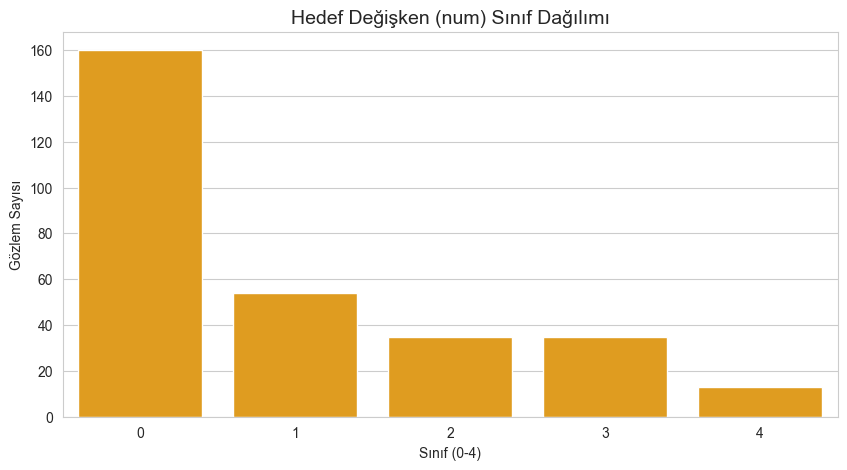

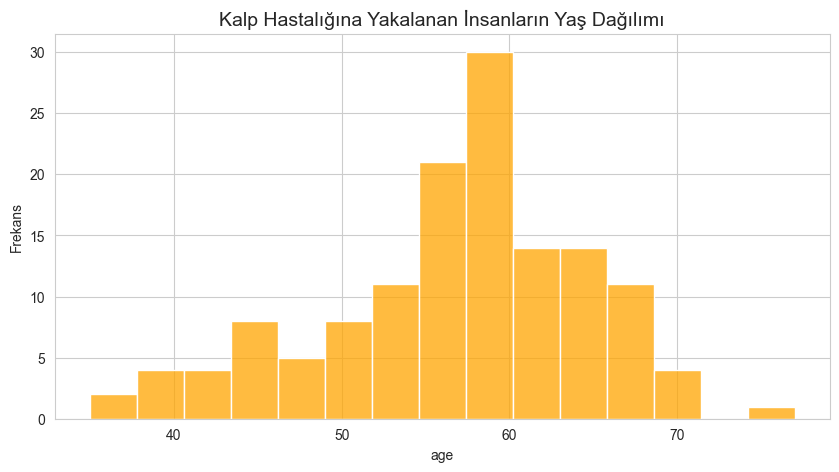

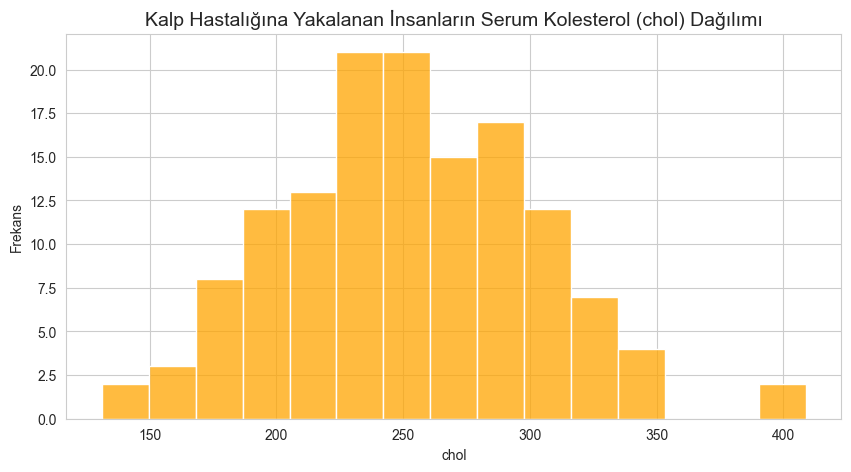

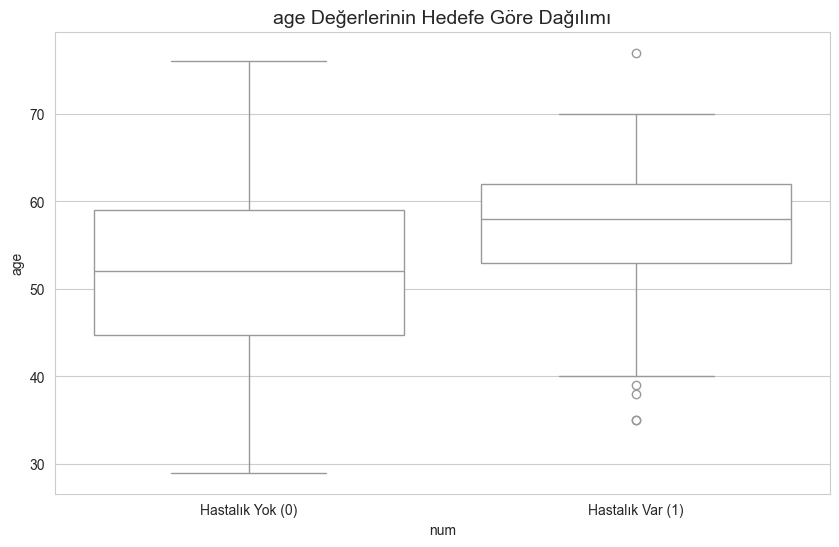

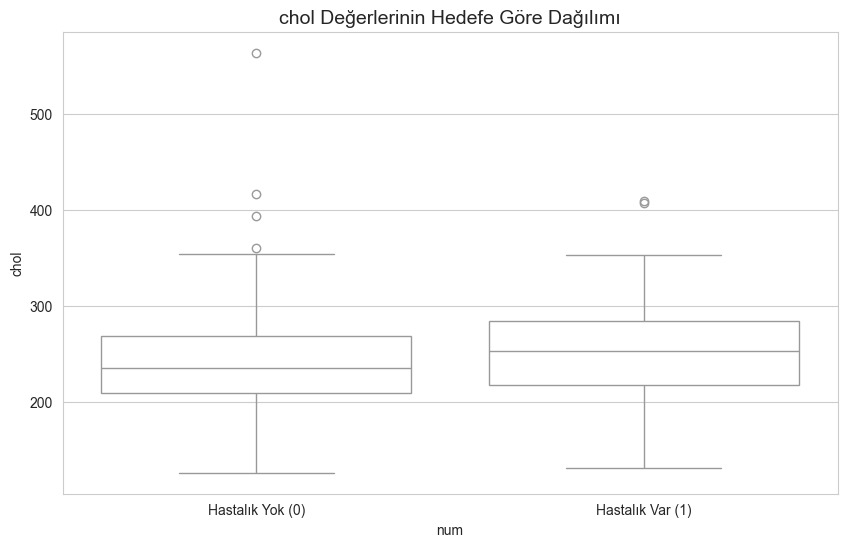

In [4]:
# 3. GÖRSELLEŞTİRME (EDA)

# Şekil 1: Hedef Değişken (num) Sınıf Dağılımı
plt.figure(figsize=(10, 5))
sns.countplot(x='num', data=df, color='orange')
plt.title('Hedef Değişken (num) Sınıf Dağılımı', fontsize=14)
plt.xlabel('Sınıf (0-4)')
plt.ylabel('Gözlem Sayısı')
plt.show()

# Şekil 2: Yaş (age) Dağılımı
plt.figure(figsize=(10, 5))
sns.histplot(df[df['num'] > 0]['age'], bins=15, color='orange', kde=False) # Sadece hasta olanlar
plt.title('Kalp Hastalığına Yakalanan İnsanların Yaş Dağılımı', fontsize=14)
plt.xlabel('age')
plt.ylabel('Frekans')
plt.show()

# Şekil 3: Serum Kolesterol (chol) Dağılımı
plt.figure(figsize=(10, 5))
sns.histplot(df[df['num'] > 0]['chol'], bins=15, color='orange', kde=False)
plt.title('Kalp Hastalığına Yakalanan İnsanların Serum Kolesterol (chol) Dağılımı', fontsize=14)
plt.xlabel('chol')
plt.ylabel('Frekans')
plt.show()

# Şekil 4: Yaş Değerlerinin Hedefe Göre Dağılımı (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='num', y='age', data=df_binary, palette={"0": "white", "1": "white"}, flierprops={"marker": "o"})
# Not: Görünümü rapora benzetmek için binary kullandım (0: Yok, 1: Var)
plt.xticks([0, 1], ['Hastalık Yok (0)', 'Hastalık Var (1)'])
plt.title('age Değerlerinin Hedefe Göre Dağılımı', fontsize=14)
plt.show()

# Şekil 5: Kolesterol Değerlerinin Hedefe Göre Dağılımı (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='num', y='chol', data=df_binary, palette={"0": "white", "1": "white"})
plt.xticks([0, 1], ['Hastalık Yok (0)', 'Hastalık Var (1)'])
plt.title('chol Değerlerinin Hedefe Göre Dağılımı', fontsize=14)
plt.show()

In [5]:
# 4. ÖN İŞLEME VE SPLIT

# Aykırı Değer Temizleme (Basit Z-Score Mantığı veya IQR) [cite: 164]
# Burada Chol > 400 gibi çok bariz aykırıları manuel filtreleyebiliriz (Raporda bahsedildiği gibi)
# df_binary = df_binary[df_binary['chol'] < 400] # İsteğe bağlı aktif edilebilir.

X = df_binary.drop('num', axis=1)
y = df_binary['num']

# Eğitim ve Test Seti Ayrımı (%70 - %30 veya %80 - %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Kategorik ve Sayısal Sütunların Belirlenmesi
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Pipeline Oluşturma
# Sayısal veriler: Standartlaştırma [cite: 165]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Kategorik veriler: One-Hot Encoding [cite: 166]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor Birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# PCA (Boyut İndirgeme) Ekleme [cite: 167]
# PCA bileşen sayısını varyansın %90'ını koruyacak şekilde seçebiliriz veya sabit sayı (örn: 10) verebiliriz.
pca = PCA(n_components=0.95)

MODEL SONUÇLARI VE METRİKLERİ:

------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.8444 | Precision: 0.8889 | Recall: 0.7619
------------------------------------------------------------
Model: Naive Bayes
Accuracy: 0.8778 | Precision: 0.9189 | Recall: 0.8095
------------------------------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.8333 | Precision: 0.8462 | Recall: 0.7857
------------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.8444 | Precision: 0.8684 | Recall: 0.7857
------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8333 | Precision: 0.8462 | Recall: 0.7857
------------------------------------------------------------

ÖZET TABLO:
                    Model  Accuracy  Precision    Recall
1             Naive Bayes  0.877778   0.918919  0.809524
0     Logistic Regression  0.844444   0.888889  0.761905
3  Support Vector Machin

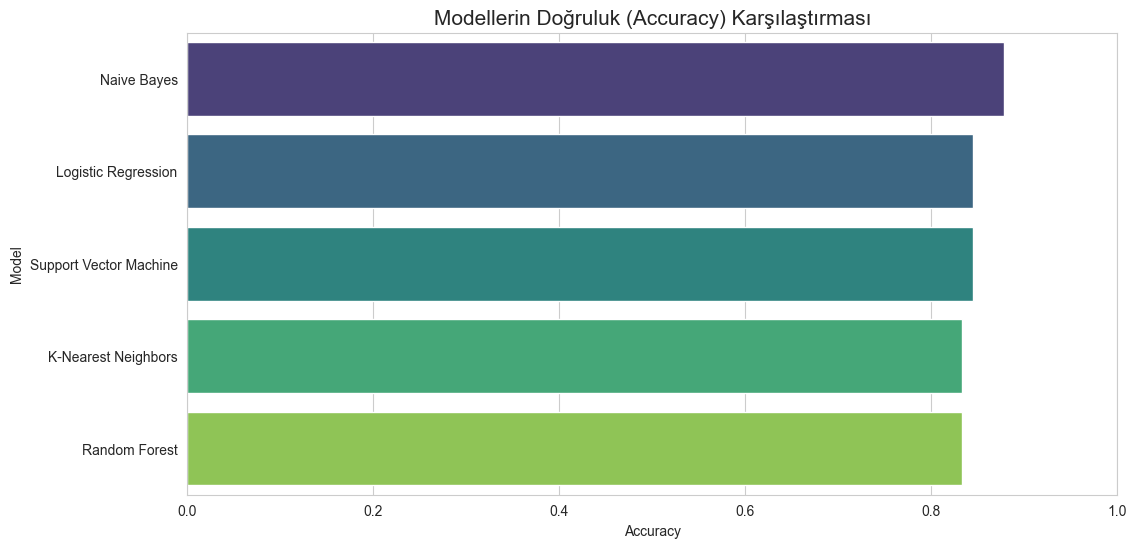

In [6]:
# 5. MODELLEME

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Modellerin Tanımlanması
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

print("MODEL SONUÇLARI VE METRİKLERİ:\n")
print("-" * 60)

for name, model in models.items():
    # Pipeline: Ön İşleme -> PCA -> Model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('pca', pca),
                          ('classifier', model)])
    
    # Eğitim
    clf.fit(X_train, y_train)
    
    # Tahmin
    y_pred = clf.predict(X_test)
    
    # Metrikler [cite: 175]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec})
    
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
    print("-" * 60)

# Sonuçların Tablolaştırılması
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nÖZET TABLO:")
print(results_df)

# Sonuçların Görselleştirilmesi
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Modellerin Doğruluk (Accuracy) Karşılaştırması', fontsize=15)
plt.xlim(0, 1)
plt.show()

In [7]:
# 4. ÖN İŞLEME VE SPLIT

# Aykırı Değer Temizleme (Basit Z-Score Mantığı veya IQR) [cite: 164]
# Burada Chol > 400 gibi çok bariz aykırıları manuel filtreleyebiliriz (Raporda bahsedildiği gibi)
# df_binary = df_binary[df_binary['chol'] < 400] # İsteğe bağlı aktif edilebilir.

X = df_binary.drop('num', axis=1)
y = df_binary['num']

# Eğitim ve Test Seti Ayrımı (%70 - %30 veya %80 - %20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Kategorik ve Sayısal Sütunların Belirlenmesi
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Pipeline Oluşturma
# Sayısal veriler: Standartlaştırma [cite: 165]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Kategorik veriler: One-Hot Encoding [cite: 166]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessor Birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# PCA (Boyut İndirgeme) Ekleme [cite: 167]
# PCA bileşen sayısını varyansın %90'ını koruyacak şekilde seçebiliriz veya sabit sayı (örn: 10) verebiliriz.
# pca = PCA(n_components=0.95)

MODEL SONUÇLARI VE METRİKLERİ:

------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.8333 | Precision: 0.8649 | Recall: 0.7619
------------------------------------------------------------
Model: Naive Bayes
Accuracy: 0.8556 | Precision: 0.9143 | Recall: 0.7619
------------------------------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.8556 | Precision: 0.8372 | Recall: 0.8571
------------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.8556 | Precision: 0.8919 | Recall: 0.7857
------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8444 | Precision: 0.8684 | Recall: 0.7857
------------------------------------------------------------

ÖZET TABLO:
                    Model  Accuracy  Precision    Recall
1             Naive Bayes  0.855556   0.914286  0.761905
2     K-Nearest Neighbors  0.855556   0.837209  0.857143
3  Support Vector Machin

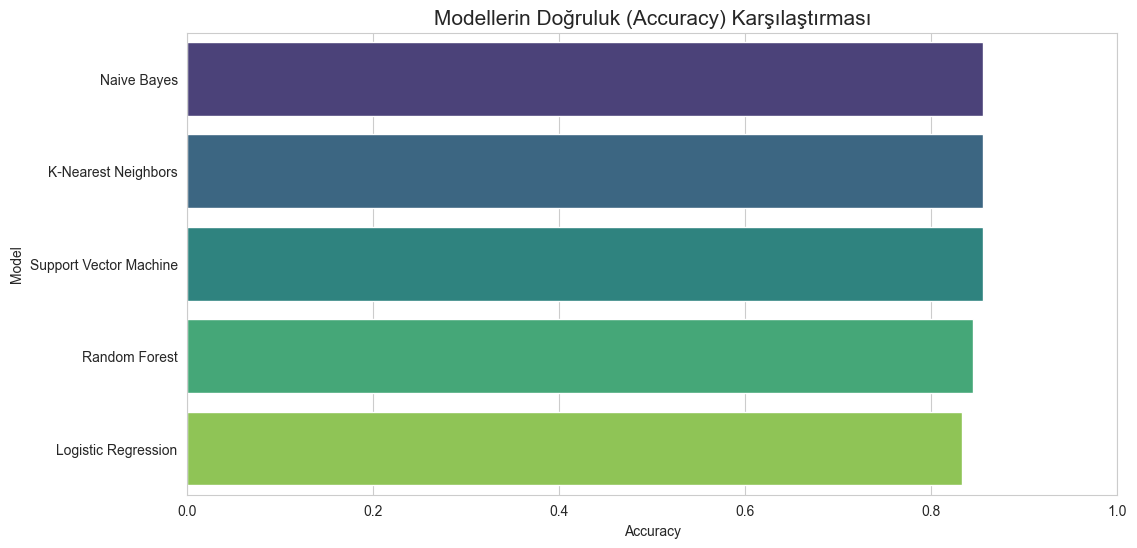

In [8]:
# 5. MODELLEME

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Modellerin Tanımlanması
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

print("MODEL SONUÇLARI VE METRİKLERİ:\n")
print("-" * 60)

for name, model in models.items():
    # Pipeline: Ön İşleme -> PCA -> Model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Eğitim
    clf.fit(X_train, y_train)
    
    # Tahmin
    y_pred = clf.predict(X_test)
    
    # Metrikler [cite: 175]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec})
    
    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
    print("-" * 60)

# Sonuçların Tablolaştırılması
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nÖZET TABLO:")
print(results_df)

# Sonuçların Görselleştirilmesi
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Modellerin Doğruluk (Accuracy) Karşılaştırması', fontsize=15)
plt.xlim(0, 1)
plt.show()

PCA'LI

------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.8444 | Precision: 0.8889 | Recall: 0.7619
------------------------------------------------------------
Model: Naive Bayes
Accuracy: 0.8778 | Precision: 0.9189 | Recall: 0.8095
------------------------------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.8333 | Precision: 0.8462 | Recall: 0.7857
------------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.8444 | Precision: 0.8684 | Recall: 0.7857
------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8333 | Precision: 0.8462 | Recall: 0.7857
------------------------------------------------------------

ÖZET TABLO:
                    Model  Accuracy  Precision    Recall
1             Naive Bayes  0.877778   0.918919  0.809524
0     Logistic Regression  0.844444   0.888889  0.761905
3  Support Vector Machine  0.844444   0.868421  0.785714
2     K-Nearest Neighbors  0.833333   0.846154  0.785714
4           Random Forest  0.833333   0.846154  0.785714



PCA'SIZ

------------------------------------------------------------
Model: Logistic Regression
Accuracy: 0.8333 | Precision: 0.8649 | Recall: 0.7619
------------------------------------------------------------
Model: Naive Bayes
Accuracy: 0.8556 | Precision: 0.9143 | Recall: 0.7619
------------------------------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.8556 | Precision: 0.8372 | Recall: 0.8571
------------------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.8556 | Precision: 0.8919 | Recall: 0.7857
------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8444 | Precision: 0.8684 | Recall: 0.7857
------------------------------------------------------------

ÖZET TABLO:
                    Model  Accuracy  Precision    Recall
1             Naive Bayes  0.855556   0.914286  0.761905
2     K-Nearest Neighbors  0.855556   0.837209  0.857143
3  Support Vector Machine  0.855556   0.891892  0.785714
4           Random Forest  0.844444   0.868421  0.785714
0     Logistic Regression  0.833333   0.864865  0.761905